# WHONDRS data preprocessing notebook

We want to predict respiration rates based on:
1. small scale data (water samples - isotopes, chemical conc./presence)
2. intermediate scale data (site metadata)
3. large scale data (satellite data, stream order)

This notebook will preprocess the WHONDRS data for use with machine learning.  Preprocessing means pulling out exactly the data to be used and applying any reformatting/reordering needed to create a single input file for the machine learning.

There are multiple respiration rates per site because they come from
upstream, midstream, and downstream sampling locations.  Some site
metadata encompass the whole site and other metadata are specific to
the U, M, and D "subsites".  Here, a single respiration
rate value is linked to only the corresponding U, M, **or** D site
metadata.  For example, if it is a midstream respiration rate, only
the midstream algal mat coverage is included while the up- and down-
stream algal mat coverages are ingnored _for that value_.  This
approach helps to reduce the amount of input data to the machine
learning which should yield better results.

The data sets merged here are:
1. WHONDRS **sediment** respiration rate (the target variable for predictions), 
2. WHONDRS site metadata (range of scales, includes water depth, latitude, pH, DO),
3. WHONDRS stream order (based on NHDPlusV2),
4. WHONDRS FTICR chemical presence/absence,
5. WHONDRS H and O stable isotopes, and
6. RiverATLAS stream order and water depth.

The last set is included because RiverATLAS is at a different resolution than NHDPlusV2 (used by WHONDRS team) so there is a systematic offset/bias in the stream order data.  We need to use RiverATLAS due to global coverage while NHDPlusV2 is only US coverage.  I want to provide for explicit comparisons between RiverATLAS- and WHONDRS-sourced stream order and compare the estimates for RiverATLAS water depth to the directly measured water depth.

In [1]:
#%load_ext autoreload
#%autoreload 2
#import sys
#from pwutils import load_data,doe_graph,selected_data,show_app,workflow,pivot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
csv_path = "/pw/storage/whondrml-data/"

# Load respiration rate data

This data will be the key output of the ML models.  The presence/absence of data from each site in this data set determines all other record queries.

In [2]:
# Load the respiration rate
# DO NOT use index_col='ID'
# because ID's are not unique.
df_resp_rate = pd.read_csv(
    csv_path+"unpublished/S19S_Sediment_respiration_rates.csv",
    header=0)

# CAUTION!  Setting this value to true can result in Pandas misinterpreting
# this data for one-hot encoding.  Instead, if you wish to use imblearn, add
# a column specific to imblearn classification that is not used in training
# the ML models.
rr_int = False
if rr_int:
    # Convert respiration rates to positive integers so high numbers
    # mean high respiration rates.  Currently, the sign convention is
    # reversed where respiration rates are negative, which imply oxygen
    # consumption.  This is confusing when discussing rates and also
    # necessary to assign values to classes -> each POSITIVE integer 
    # value is considered a class in imbalanced-learn.
    # Respiration rates range from -40 to 0, so the decimal values are not
    # a significant contribution to the information here.
    df_resp_rate['rate.mg.per.L.per.h'] = np.abs(df_resp_rate['rate.mg.per.L.per.h']).astype(int)

df_resp_rate['ID'].describe()

count           180
unique           72
top       S19S_0064
freq              3
Name: ID, dtype: object

In [3]:
# Set a dictionary with the variables to be used
# (the column name in the file) and the data type.
# Multiple respiration rates at a single site
# indicate U (upstream), M (midstream), and D
# (downstream) sampling sub-sites (within ~10 to
# ~100 m of each other).
if rr_int:
    resp_data_to_use = {
        'ID':np.dtype('str'),
        'sampling_location':np.dtype('str'),
        'rate.mg.per.L.per.h':np.dtype('int')  # Make consistent with data type approach in cell above.
    }
else:
    resp_data_to_use = {
        'ID':np.dtype('str'),
        'sampling_location':np.dtype('str'),
        'rate.mg.per.L.per.h':np.dtype('float')
    }
# Pull out just the variables we want
df_resp_rate_used = df_resp_rate.loc[:, tuple(resp_data_to_use.keys())]
df_resp_rate_used

,ID,sampling_location,rate.mg.per.L.per.h
0,S19S_0006,U,-15.114286
1,S19S_0007,U,-5.276923
2,S19S_0008,U,-4.902564
3,S19S_0009,U,-7.333333
4,S19S_0010,U,-7.040000
...,...,...,...
175,S19S_0090,D,-13.317647
176,S19S_0097,D,-18.493333
177,S19S_0098,D,-7.554111
178,S19S_0099,D,-1.743386


# Load site metadata into a Pandas DataFrame

Uncomment the lines below to see the input `.csv` files directly.
Seeing the dataframes here is not that useful since the displayed
output is truncated.

In [4]:
df_site_meta = pd.read_csv(
    csv_path+"public_data/WHONDRS_S19S_SW_FTICR_Isotopes_Metadata.csv",
    header=0,
    index_col='Sample_ID')
# In this example, the Sample ID can be used to access a whole sample.
#df_site_meta.loc['S19S_0099',:]

# See the site_data_to_use dictionary in the
# Mix and Match Data cell, below.  This dictionary
# will select which columns to pull out of the
# site metadata file.  This dictionary is *not*
# here, as the other selection dictionaries,
# because up, mid, and downstream sites are
# selected separately based on the respiration
# rate data.

# Load Stream order data into a Pandas DataFrame

In [5]:
df_stream_order = pd.read_csv(
    csv_path+"unpublished/WHONDRS_S19S_StreamOrder.csv",
    header=0,
    index_col='ID')

# Select which columns to use from this file
stream_order_data_to_use = {
    'Stream_Order':np.dtype('float')
}

# Manual change to outlier at Mayfield Creek
# Set to 7 (large river) but on RiverAtlas maps,
# clearly small stream.  Set to 2 since there
# are no other clear streams/features nearby
# but there is a clear Stream_Order offset
# due to the higher resolution used to determine
# the WHONDRS data set.
df_stream_order.loc['S19S_0022','Stream_Order'] = 2.0

df_stream_order

,River_Name,City,State/Province/Region,Country,Location_Notes,Longitude,Latitude,Stream_Order,SO_Notes
ID,,,,,,,,,
S19S_0001,Fraser River,Hope,British Columbia,Canada,NaN,-121.450470,49.386090,9.0,NaN
S19S_0003,Thompson River,Kamloops,British Columbia,Canada,NaN,-120.366470,50.688800,7.0,NaN
S19S_0004,South Thompson River,Chase,British Columbia,Canada,NaN,-119.721960,50.775100,6.0,NaN
S19S_0005,Assiniboine River,Winnipeg,Manitoba,Canada,NaN,-97.407810,49.868870,NaN,NaN
S19S_0006,Dead Run,Baltimore,Maryland,USA,NSF Long Term Ecological Research (LTER) site:...,-76.717163,39.311369,2.0,NaN
...,...,...,...,...,...,...,...,...,...
S19S_0096,Orco River,San Benigno Canavese,NaN,Italy,NaN,7.805425,45.247337,NaN,NaN
S19S_0097,Logan River,Logan,Utah,USA,NaN,-111.886500,41.720847,5.0,NaN
S19S_0098,Logan River,Logan,Utah,USA,NaN,-111.580533,41.950204,3.0,NaN


# Load chemical presence/absence data into Pandas DataFrame

In [6]:
# In this file, site ID is in the header...
# (so sites/samples are along the columns rather than the rows.)
df_chem_pres = pd.read_csv(
    csv_path+"unpublished/Processed_S19S_Sediments_Water.csv",
    header=0,
    index_col='Mass')

# Instead of transposing the dataframe and creating a new
# dataframe that is indexed by sample_id (e.g. somthing like:
# df_chem_pres_transposed = df_chem_pres.transpose().set_index()),
# note that there are U, M, and D data points as well as P2,
# p05 designations. The solution is to select columns of data
# based on sample similar to the site metadata.

# The bigger problem is that the data are not 100% consistent
# in that only some sites have U, M, D subsamples, etc.  There
# can be anywhere from 0 to 6 entries per sample_ID, some of
# which are U,M,D and some are replicates.  So here, we will
# pull out all the values associated with a sample_id, add them
# together, and any values greater than 0 are replaced with 1.
# This means all UMD subsamples, replicates, and ion-accumulation
# times (the PXX values) are merged together into a single
# presence-absence string for that site.  This means all U,
# M, D subsamples that were different, above, all have the same
# presence-absence string.

# We will select a string of 0's and 1's from a column based
# on the sample_id.  We may want to weight the 0's and 1's based
# on the associated variables with each chemical (e.g. AI, DBE, NOSC).
# For example, the final value could be:
# (AI + DBE + NOSC)*(presence/absence)
# This weighting should be implemented below in the Mix and Match
# cell.

#====================================================
# Set dictionary for mapping units of this data set
#====================================================
#
all_chems = False
if (all_chems):
    # Approach 1 - all chemical presence/absence
    # Here, we can set up the data dictionary based on a list of the
    # chemical names from the dataframe index list.  One unique identifier
    # of the chemicals is the mass column, so use that as the index.
    # Note that we use a float data type here to allow for the AI, DBE,
    # NOSC weighting later, if desired.

    chem_list = df_chem_pres.index.tolist()
    chem_list_names = ["Mass_"+str(ss) for ss in chem_list]
    chem_pres_data_to_use = dict.fromkeys(chem_list_names, np.dtype("float"))
    
else:
    # Approach 2 - use chemical presence/absence
    # to weight AI, DBE, and NOSC variables (and a)
    # few others.  Here, I will use the column names
    # in the chemical presence/absence file to generate
    # a presence/absence weighted value for each variable.
    # There are a few others to choose from, but these
    # seem to be the most relevant.
    
    chem_pres_data_to_use = {
        #'AI':np.dtype('float'),
        #'AI_Mod':np.dtype('float'),
        #'DBE':np.dtype('float'),
        #'DBE_O':np.dtype('float'),
        'NOSC':np.dtype('float'),
        #'GFE':np.dtype('float'),
        'lamO2':np.dtype('float'),
        'lamHCO3':np.dtype('float'),
        'n_chems':np.dtype('float'),
        'skew_lamO2':np.dtype('float'),
        'skew_lamHCO3':np.dtype('float'),
        'perc_AminoSugar':np.dtype('float'),
        'perc_Carb':np.dtype('float'),
        'perc_ConHC':np.dtype('float'),
        'perc_Lignin':np.dtype('float'),
        'perc_Lipid':np.dtype('float'),
        'perc_Other':np.dtype('float'),
        'perc_Protein':np.dtype('float'),
        'perc_Tannin':np.dtype('float'),
        'perc_UnsatHC':np.dtype('float')
    }
    
len(chem_pres_data_to_use.keys())


15

In [7]:
# WORKING HERE:
# Add number chems, 

1.836341861759573
7176.0 0.04486737662764771


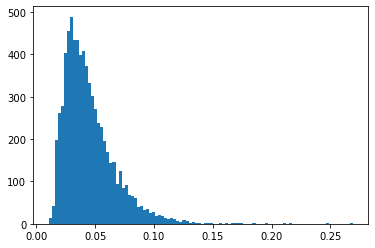

In [8]:
# These lines are an example of the sample_id filter,
# add all records, and convert records to a single number.
# Also, the len() operator is helpful here to check that
# the number of records matches the number of entries
# in the data dictionary, above.  This example is implemented
# over a loop for each sample_id in the Mix and Match cell,
# below.
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
if (all_chems):
    # Find all the records associated with a given
    # sample_id and add up all presence/absence.  Then,
    # make a single presence absence list by converting
    # any non-zero numbers to 1.
    out = df_chem_pres.filter(regex="S19S_0006").sum(axis=1) > 0
    len(out.astype(float))
    
else:
    # Find all the records associated with a given
    # sample_id and add up all presence/absence.  As above,
    # convert all subsamples into a single presence/absence
    # list (we are not counting how many of which type of chemicals
    # are detected, only storing presence/absence because
    # presence/absence, from the beginning, is NOT
    # about chemical concentration.).
    out_tf = df_chem_pres.filter(regex="S19S_0006").sum(axis=1) > 0
    out_01 = out_tf.astype(float)
    
    # Now, create an "average detected index" (ADI) - this
    # will be looped over in the cell below for multiple 
    # indeces.  Here, I am just testing a single index.
    adi_list = df_chem_pres['lamO2']
    adi_avg = np.multiply(adi_list,out_01).sum()/out_01.sum()
    
    masked = adi_list*out_01
    just_this_sample = masked[masked != 0]
    print(sp.stats.skew(just_this_sample))
    # Number of chems is out_01.sum()
    print(out_01.sum(),adi_avg)
    
    # I was able to recreate these numbers with the following
    # bash lines and the Generic Mapping Tools.  For out_01.sum(),
    # awk -F, ' NR>1 {print $46+$47+$48+$49+$50}' Processed_S19S_Sediments_Water.csv | gmtmath STDIN 0 GT SUM -Sl =

    # For adi_avg,
    # awk -F, 'NR>1{print $24}' Processed_S19S_Sediments_Water.csv > NOSC.tmp
    # awk -F, ' NR>1 {print $46+$47+$48+$49+$50}' Processed_S19S_Sediments_Water.csv | gmtmath STDIN 0 GT NOSC.tmp MUL SUM 7176 DIV -Sl =
    
    fig, ax = plt.subplots()
    ax.hist(just_this_sample,bins=100)


# Load sample isotope data into Pandas DataFrame

In [9]:
df_isotopes = pd.read_csv(
    csv_path+"public_data/WHONDRS_S19S_Data_Isotopes.csv",
    header=0,
    index_col='Sample_ID')

# Select which columns to use from this file
isotopes_data_to_use = {
    'del_2H_permil':np.dtype('float'),
    'del_18O_permil':np.dtype('float')
}

# Load RiverATLAS-derived stream order & depth

In [10]:
df_ra_so_depth = pd.read_csv(
    "../GLORICH_HydroSHEDS/step_04_output.csv",
    header=0,
    index_col='WH_ID')

# Select which columns to use from this file
ra_so_depth_data_to_use = {
    'RA_SO':np.dtype('float'),
    'RA_dm':np.dtype('float'),
    'RA_ms_av':np.dtype('float'),
    'RA_ms_mn':np.dtype('float'),
    'RA_ms_mx':np.dtype('float'),
    'run_mm_cyr':np.dtype('float'),
    'dor_pc_pva':np.dtype('float'),
    'gwt_cm_cav':np.dtype('float'),
    'ele_mt_cav':np.dtype('float'),
    'slp_dg_cav':np.dtype('float'),
    'sgr_dk_rav':np.dtype('float'),
    'tmp_dc_cyr':np.dtype('float'),
    'tmp_dc_cdi':np.dtype('float'),
    'tmp_dc_uyr':np.dtype('float'),
    'pre_mm_cyr':np.dtype('float'),
    'pre_mm_cdi':np.dtype('float'),
    'pre_mm_uyr':np.dtype('float'),
    'aet_mm_cyr':np.dtype('float'),
    'aet_mm_cdi':np.dtype('float'),
    'aet_mm_uyr':np.dtype('float'),
    'cmi_ix_cyr':np.dtype('float'),
    'cmi_ix_cdi':np.dtype('float'),
    'cmi_ix_uyr':np.dtype('float'),
    'snw_pc_cyr':np.dtype('float'),
    'snw_pc_cmx':np.dtype('float'),
    'snw_pc_uyr':np.dtype('float'),
    'for_pc_cse':np.dtype('float'),
    'for_pc_use':np.dtype('float'),
    'crp_pc_cse':np.dtype('float'),
    'crp_pc_use':np.dtype('float'),
    'pst_pc_cse':np.dtype('float'),
    'pst_pc_use':np.dtype('float'),
    'ire_pc_cse':np.dtype('float'),
    'ire_pc_use':np.dtype('float'),
    'gla_pc_cse':np.dtype('float'),
    'gla_pc_use':np.dtype('float'),
    'prm_pc_cse':np.dtype('float'),
    'prm_pc_use':np.dtype('float'),
    'pac_pc_cse':np.dtype('float'),
    'pac_pc_use':np.dtype('float'),
    'cly_pc_cav':np.dtype('float'),
    'cly_pc_uav':np.dtype('float'),
    'slt_pc_cav':np.dtype('float'),
    'slt_pc_uav':np.dtype('float'),
    'snd_pc_cav':np.dtype('float'),
    'snd_pc_uav':np.dtype('float'),
    'soc_th_cav':np.dtype('float'),
    'soc_th_uav':np.dtype('float'),
    'swc_pc_cyr':np.dtype('float'),
    'swc_pc_cdi':np.dtype('float'),
    'swc_pc_uyr':np.dtype('float'),
    'kar_pc_cse':np.dtype('float'),
    'kar_pc_use':np.dtype('float'),
    'ero_kh_cav':np.dtype('float'),
    'ero_kh_uav':np.dtype('float'),
    'pop_ct_csu':np.dtype('float'),
    'pop_ct_usu':np.dtype('float'),
    'ppd_pk_cav':np.dtype('float'),
    'ppd_pk_uav':np.dtype('float'),
    'urb_pc_cse':np.dtype('float'),
    'urb_pc_use':np.dtype('float'),
    'nli_ix_cav':np.dtype('float'),
    'nli_ix_uav':np.dtype('float'),
    'rdd_mk_cav':np.dtype('float'),
    'rdd_mk_uav':np.dtype('float'),
    'hft_ix_c09':np.dtype('float'),
    'hft_ix_u09':np.dtype('float'),
    'gdp_md_cav':np.dtype('float'),
    'gdp_md_usu':np.dtype('float'),
    'hdi_ix_cav':np.dtype('float')
}

# Manual modification for one data point: S19S_0060's stream
# order based on RiverATLAS (2) differs substantially from the
# WHONDRS stream order (7).  Upon examination of S19S_0060.pdf,
# retained in the GLORICH_HydroSHEDS directory,
# this mismatch is likely due to a resolution artefact.  Manually
# reset this stream order to be consistent.  However, *DO NOT*
# set to 7 (the WHONDRS number) because of the consistent offset
# bias in the RiverATLAS stream order values due to the lower
# resolution of RiverATLAS.  Instead, set to 6 to be consistent
# with the other RiverATLAS stream orders.
print(df_ra_so_depth.loc['S19S_0060','RA_SO'])
df_ra_so_depth.loc['S19S_0060','RA_SO'] = 6
print(df_ra_so_depth.loc['S19S_0060','RA_SO'])

# There may be one other outlier in the the RA-WHONDRS plot
# of Stream Order - S19S_0042 - with WHONDRS SO = 1 and
# RA SO = 3.  Leave this as is since it is possible that there
# could be an unresolved stream in this region from which the
# WHONDRS data point was picked.  Futhermore, this area is
# Shark River Slough whose topography is extremely flat so
# it may be problematic to find river networks here.
df_ra_so_depth['RA_ms_av'] = df_ra_so_depth['RA_cms_cyr']/df_ra_so_depth['RA_xam2']
df_ra_so_depth['RA_ms_mn'] = df_ra_so_depth['RA_cms_cmn']/df_ra_so_depth['RA_xam2']
df_ra_so_depth['RA_ms_mx'] = df_ra_so_depth['RA_cms_cmx']/df_ra_so_depth['RA_xam2']
df_ra_so_depth.describe()

2
6


,lon,lat,RA_cms_cyr,RA_cms_cmn,RA_cms_cmx,RA_SO,RA_dm,RA_lm,my_lm,RA_xam2,...,rdd_mk_uav,hft_ix_c09,hft_ix_u09,gdp_md_cav,gdp_md_usu,hdi_ix_cav,dist_m,RA_ms_av,RA_ms_mn,RA_ms_mx
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,...,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,-91.256725,40.798204,212.575495,58.195680,521.321680,2.608247,1.045103,6.016804,5811.546194,205.832484,...,837.237113,156.577320,114.195876,0.050348,10140.774737,919.628866,569.387635,0.504075,0.186102,1.178296
std,40.457104,8.643528,754.054775,200.328333,1901.594573,1.976722,1.802086,4.443791,4204.218779,714.262855,...,1679.485547,127.139264,108.249484,0.008669,26243.364752,42.586021,902.493104,0.297170,0.162620,0.601778
min,-149.403330,18.109960,0.010000,0.000000,0.049000,1.000000,0.066901,0.540000,541.887438,0.104110,...,0.000000,0.000000,0.000000,0.031671,0.000000,803.000000,0.001607,0.032072,0.000000,0.118779
25%,-119.023130,35.966194,0.239000,0.088000,0.512000,1.000000,0.166486,2.670000,2672.145715,0.776782,...,68.000000,48.000000,34.000000,0.043949,1.296630,901.000000,66.924217,0.303101,0.072949,0.775089
50%,-97.407810,39.890640,0.455000,0.199000,1.149000,2.000000,0.240231,5.130000,4861.277992,1.558590,...,265.000000,111.000000,61.000000,0.050142,58.682200,934.000000,155.940635,0.455699,0.143567,1.084565
75%,-78.008030,43.954722,7.164000,1.842000,25.724000,4.000000,1.033640,7.760000,7498.546475,17.467900,...,614.000000,251.000000,199.000000,0.055867,2559.590000,950.000000,708.606576,0.686796,0.257888,1.460987
max,128.964600,68.669530,3512.542000,967.051000,9102.739000,7.000000,7.808220,21.350000,21423.841115,3399.230000,...,9656.000000,438.000000,420.000000,0.071149,148582.000000,955.000000,5853.201731,1.342110,1.074758,2.680542


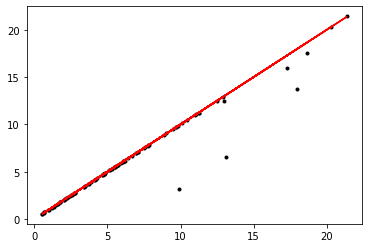

In [11]:
# Sanity checks on RiverAtlas based length and reach length computed from GMT
# GMT values are a bit smaller due to possibility of points being clipped during
# step 04 search.
fig, ax = plt.subplots()
ax.plot(df_ra_so_depth['RA_lm'].values,df_ra_so_depth['my_lm'].values/1000.0,'k.')
ax.plot(df_ra_so_depth['RA_lm'].values,df_ra_so_depth['RA_lm'].values,'r-')

# Load/API-pull large scale data from Subsurface Insights into Pandas DataFrame

In [12]:
# We may need to pull lon/lat from the site metadata
# in order to look up large-scale index data from SI.

# Mix and match data for each respiration rate record

In [13]:
# As with many things in Python, you need to be very careful how
# you access it.  See:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-view-versus-copy
# Here, I pull out just the columns I think are most related to
# the intermediate scale data that are available in this file.
# Water sample scale data (e.g. pH, DO, temperature, can be
# included in the small scale analysis.)  Note that quite a
# few columns are commented out WITHOUT COMMMENTS - this means
# that they are simply removed for now so that I can start
# with a simple data set.  I want a mix of one-hot and numerical
# data to check the pipeline.  I did not check for missing
# data in the uncommented variables.

# Also, which columns that are pulled out depends on the
# U, M, D status of the respiration rate sample.  So here
# we loop over the respiration rates and adjust the
# names of the columns we pull out from the site metadata
# file based on the respiration rate U, M, D.
for row in df_resp_rate_used.index:

    # Determine sample_id
    sample_id = df_resp_rate_used.iloc[row,0]
    
    # Determine U, M, or D (up, mid, or down-stream)
    umd = df_resp_rate_used.iloc[row,1]
    
    # Determine respiration rate
    resp_rate = df_resp_rate_used.iloc[row,2]
    
    # Set a dictionary with the variables to be used
    # (the column name in the file) and the data type.
    site_data_to_use = {
#        'Sample_ID':np.dtype('str'),   # This is already set to index
        'General_Vegetation':'category',
        'Hydrogeomorphology':'category',
        'River_Gradient':'category',
#       'Intermittent_or_Perennial',  # MISSING DATA
        'Sediment':'category',
        umd+'S_Latitude_dec.deg':np.dtype('float'),
#        umd+'S_Longitude_dec.deg':np.dtype('float')   # Less climatically relevant than latitude
        umd+'S_Water.Column.Height_cm':np.dtype('float'),
        umd+'S_Depositional.Type':'category',
        umd+'S_Algal.Mat.Coverage':'category',
        umd+'S_Macrophyte.Coverage':'category',
        umd+'S_Sunlight.Access_Perc.Canopy.Cover':'category',
        'SW_pH':np.dtype('float'),
        'DO_perc.sat':np.dtype('float'),
        'DO_mg.per.L':np.dtype('float'),
        'SW_Temp_degC':np.dtype('float')
#       'Discharge_Link',  # Comment out because URL to external data.
#       'Primary.Sources.Flow.Variation',   # Missing Data
#       'Met.Station.Nearby',
#       'Met.Station',
#       'Precipitation.Within.Week',
#       'Number.Days.Since.Precip',
#       'Dam.Upstream.Site',
#       'Dam',   # Comment out because lots of Not_Provided
#       'Contamination.Source.Upstream'
    }
    
    # Pull out just the variables we want
    df_site_meta_used = df_site_meta.loc[sample_id, 
        list(site_data_to_use.keys())]
    
    df_stream_order_used = df_stream_order.loc[sample_id, 
        list(stream_order_data_to_use.keys())]

    # For solution on how to search for multiple columns:
    # See https://stackoverflow.com/questions/12569730/sum-all-columns-with-a-wildcard-name-search-using-python-pandas
    if (all_chems):
        # This will append all the chemical presence/absence data
        df_tmp = df_chem_pres.filter(regex=sample_id).sum(axis=1) > 0
        df_chem_pres_used = df_tmp.astype(float)
    else:
        # This will append only the *requested*
        # average detected indeces.
        df_tmp = df_chem_pres.filter(regex=sample_id).sum(axis=1) > 0
        df_01 = df_tmp.astype(float)
    
        # Make an empty dataframe whose values will be
        # filled in.
        df_adi_used = pd.DataFrame(
            columns=list(chem_pres_data_to_use.keys()),
            index=[sample_id])
    
        # Now, compute the "average detected index" (ADI) for
        # each requested variable.
        # TO DO: make this more intelligent by creating a framework
        # that names variables according to op_var where op is the
        # operator (e.g. avg, n, skew, percent) and var is the feature
        # in the data table that that operator will work on.  A loop
        # will look like:
        # for each name:
        #     get operator_name
        #     get variable_name
        #     if operator == type1:
        #         operate
        #     elif operator == type2:
        #         operate
        #     ...
        #     else:
        #         operator not recognized, panic
        #--------------------------------------------------------------
        for adi_name in chem_pres_data_to_use.keys():
            if adi_name == "n_chems":
                # Special case for number of chemicals
                df_adi_used[adi_name] = df_01.sum()
                
            elif adi_name == "skew_lamO2":
                # Special case for lamO2 skewness:
                adi_list = df_chem_pres['lamO2']
                masked = adi_list*df_01
                just_this_sample = masked[masked != 0]
                df_adi_used[adi_name] = sp.stats.skew(just_this_sample)
                
            elif adi_name == "skew_lamHCO3":
                # Special case for lamHCO3 skewness:                
                adi_list = df_chem_pres['lamHCO3']
                masked = adi_list*df_01
                just_this_sample = masked[masked != 0]
                df_adi_used[adi_name] = sp.stats.skew(just_this_sample)
                
            elif adi_name[0:4] == "perc":
                # Special case for percent of category
                # Get the categories and name of requested category
                adi_list = df_chem_pres['Class']
                this_category = adi_name[5:len(adi_name)]
                categories_this_sample = adi_list[df_tmp]
                total_this_sample = np.shape(categories_this_sample)[0]
                present_this_category = categories_this_sample == this_category
                df_adi_used[adi_name] = present_this_category.astype(int).sum()/total_this_sample
                
            else:
                adi_list = df_chem_pres[adi_name]
                adi_avg = np.multiply(adi_list,df_01).sum()/df_01.sum()
                df_adi_used[adi_name] = adi_avg
            
        # Done with ADI looping, but still need to change
        # the dataframe into exactly the same format
        # as the other data sets' dataframes
        df_chem_pres_used = df_adi_used.iloc[0,:]

    # Finished with chemical presence/absence.
        
    # Missing samples in isotopes requires checking and filling
    if (sample_id+'_ISO-1' in df_isotopes.index):
        df_isotopes_used = df_isotopes.loc[
            sample_id+'_ISO-1',
            list(isotopes_data_to_use.keys())]
        
    else:
        # This sample is not present in the stream order
        # data set so fill it with NaN.
        df_isotopes_used = pd.DataFrame(
            columns=list(isotopes_data_to_use.keys()), 
            index=[sample_id]).iloc[0,:]
        
    df_ra_so_depth_used = df_ra_so_depth.loc[sample_id, 
        list(ra_so_depth_data_to_use.keys())]
    
    # Append site metadata, stream order, chemical presence,
    # isotopes, and respiration rate to data for this sample.
    row_append_1 = np.append(
        df_site_meta_used.values,
        df_stream_order_used.values,
        axis=0)
    
    row_append_2 = np.append(
        row_append_1,
        df_chem_pres_used.values,
        axis=0)
    
    row_append_3 = np.append(
        row_append_2,
        df_isotopes_used.values,
        axis=0)
    
    row_append_4 = np.append(
        row_append_3,
        df_ra_so_depth_used.values,
        axis=0)
    
    row_of_data = np.append(
        row_append_4,
        [resp_rate],
        axis=0)
    
    #============================================================
    # Original lines
    #row_of_data = np.append(df_site_meta_used.values,[resp_rate],axis=0)
    
    # This is the inplace version of row_of_data.reshape(1,-1)
    # to force numpy and pandas to view this row as 1x10 (2D)
    # and not just a 10 unit list (1D).
    row_of_data.shape = (1,-1)
    #============================================================

    if row == 0:        
        # Merge data type dictionaries to reflect the
        # appending above.  We need to do this so we
        # know the data types of the data we're working
        # with in the final step (see next cell).
        all_data_types = site_data_to_use.copy()
        all_data_types.update(stream_order_data_to_use)
        all_data_types.update(chem_pres_data_to_use)
        all_data_types.update(isotopes_data_to_use)
        all_data_types.update(ra_so_depth_data_to_use)
        all_data_types.update(
            {'rate.mg.per.L.per.h':resp_data_to_use['rate.mg.per.L.per.h']})
        
        # Initialize numpy array to store all the data
        all_data = row_of_data
        
    else:    
        # Append to the data storage
        all_data_tmp = np.append(all_data,row_of_data,axis=0)
        all_data = all_data_tmp
        del all_data_tmp
        
# Initialize output dataframe with
# rows from the respiration rate data
# and columns from the data we want.
df_all_data = pd.DataFrame(
    data=all_data,
    index=df_resp_rate_used.index,
    columns=list(all_data_types.keys()))
df_all_data

,General_Vegetation,Hydrogeomorphology,River_Gradient,Sediment,US_Latitude_dec.deg,US_Water.Column.Height_cm,US_Depositional.Type,US_Algal.Mat.Coverage,US_Macrophyte.Coverage,US_Sunlight.Access_Perc.Canopy.Cover,...,nli_ix_cav,nli_ix_uav,rdd_mk_cav,rdd_mk_uav,hft_ix_c09,hft_ix_u09,gdp_md_cav,gdp_md_usu,hdi_ix_cav,rate.mg.per.L.per.h
0,Broadleaf deciduous tree. Shrub,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (gt2mm),39.311813,17,Pool lip,Low,No,Full sunlight (0-20% canopy cover),...,6300,6300,9656,9656,365,365,0.064307,2057.21,953,-15.1143
1,Needleleaf evergreen tree. Shrub,Single-channel straight,Relatively steep gradient (e.g. mountainous or...,Sand,37.05229,3,Pool lip,No,Low,No or almost no direct sunlight (gt80% canopy ...,...,0,0,5,10,3,3,0.055768,0.327264,951,-5.27692
2,Needleleaf evergreen tree. Shrub,Single-channel straight,Relatively steep gradient (e.g. mountainous or...,Sand,36.961273,6,Downstream from obstacles,No,Low,Accessible direct sunlight (20-50% canopy cover),...,0,0,0,0,0,0,0.055768,0,951,-4.90256
3,Broadleaf deciduous tree. Shrub,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Silt/mud (lt0.0625mm),42.9875,6,Inside bend of a stream,Low,No,Full sunlight (0-20% canopy cover),...,2357,300,353,82,238,42,0.058978,994.888,891,-7.33333
4,Needleleaf evergreen tree,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Silt/mud (lt0.0625mm),31.667905,30,At the inside bend of a stream. in shallow wat...,Low,No,Full sunlight (0-20% canopy cover),...,2810,1700,925,831,207,136,0.04558,148582,921,-7.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Broadleaf deciduous tree,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Sand,37.291383,6,Shallow waters near the shore,No,No,No or almost no direct sunlight (gt80% canopy ...,...,1007,1000,550,543,122,123,0.058068,32.7047,950,-13.3176
176,Broadleaf deciduous tree. Shrub,Single-channel straight,Relatively flat/gentle gradient (e.g. valleys),Silt/mud (lt0.0625mm),41.720847,7.5,Shallow waters near the shore,Low,Low,Full sunlight (0-20% canopy cover),...,5253,500,2635,302,320,46,0.042655,2559.59,925,-18.4933
177,Needleleaf evergreen tree. Shrub,Single-channel straight,Relatively steep gradient (e.g. mountainous or...,Gravel/cobble (gt2mm),41.950204,5,Shallow waters near the shore,Low. No,No,Full sunlight (0-20% canopy cover),...,272,100,70,28,17,21,0.042588,0.023142,922,-7.55411
178,Broadleaf deciduous tree. Grass,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (gt2mm),39.2385932,23.37,Riffle,No,No,Full sunlight (0-20% canopy cover),...,4064,2800,1249,1245,342,232,0.047436,59623.4,925,-1.74339


In [14]:
# Compute columnwise statistics (mean, std, min, quantiles, max)
# For text based data, will display the number of results, number
# of unique results, most frequent result and how often that result
# occurred.
df_all_data.describe()

,General_Vegetation,Hydrogeomorphology,River_Gradient,Sediment,US_Latitude_dec.deg,US_Water.Column.Height_cm,US_Depositional.Type,US_Algal.Mat.Coverage,US_Macrophyte.Coverage,US_Sunlight.Access_Perc.Canopy.Cover,...,nli_ix_cav,nli_ix_uav,rdd_mk_cav,rdd_mk_uav,hft_ix_c09,hft_ix_u09,gdp_md_cav,gdp_md_usu,hdi_ix_cav,rate.mg.per.L.per.h
count,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180.000000,180.0,180,180.000000
unique,16,3,4,4,175,75,11,6,4,4,...,56,29,60,60,58,59,28.000000,64.0,23,180.000000
top,Needleleaf evergreen tree. Broadleaf deciduous...,Single-channel meandering,Relatively flat/gentle gradient (e.g. valleys),Gravel/cobble (gt2mm),43.954722,10,Shallow waters near the shore,No,No,Full sunlight (0-20% canopy cover),...,0,0,0,0,30,34,0.055481,0.0,951,-1.951367
freq,31,91,119,107,3,10,74,118,105,68,...,23,37,21,15,9,7,20.000000,13.0,36,1.000000


# Filter missing values and map ordinal data

In [15]:
# Now we need to convert text classes into
# "one-hot" or "one-of-k" data which tells
# the ML model that the data is classicative
# but not necessarily ranked (not numerical).
# This is done with a string of 0's where each
# class is represented by exactly one of the
# zeros being changed into a 1 (so one bit is
# "hot").
#
# A starting point for one-hot
# classification is here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
#
# I will use this approach for dealing
# with missing data:
# https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
# You can tell when there's missing data in columns
# in which the count line from the .describe()
# operation is less than the total number of rows.
# The missing values are translated to a string of
# all zeros in one-hot encoding.  An unresolved
# question is whether all zeros actually means
# something or whether it is truly ignored by
# the ML model.

# Some classifications overlap just nearly,so merge them
# E.g. an extra period created a whole new class in a few
# cases.
df_all_data = df_all_data.replace(
    'Relatively flat/gentle gradient (e.g.. valleys)',
    'Relatively flat/gentle gradient (e.g. valleys)')
df_all_data = df_all_data.replace(
    'Relatively steep gradient (e.g.. mountainous or hilly terrain)',
    'Relatively steep gradient (e.g. mountainous or hilly terrain)')
df_all_data = df_all_data.replace(
    'Low. The algal mat coverage is not on sediment but nearby',
    'Low')
df_all_data = df_all_data.replace('Low. No','Low')
df_all_data = df_all_data.replace(
    'Submerged aquatic macrophytes abundant without full coverage',
    'High')
df_all_data = df_all_data.replace('bison crossing in riffle','Riffle')
df_all_data = df_all_data.replace(
    'Nearshore of upstream end of sandy vegetated point bar',
    'Shallow waters near the shore')
df_all_data = df_all_data.replace(
    'At the inside bend of a stream. in shallow waters near the shore',
    'Shallow waters near the shore')

# Some numerical data has text in it, convert to numbers.
# For example, some water heights were
# reported qualitatively.  Convert from ranges to
# specific values.
df_all_data = df_all_data.replace('41.1 - may not be correctly calibrated',41.1)
df_all_data = df_all_data.replace('4.62 - may not be correctly calibrated',4.62)
df_all_data = df_all_data.replace('gt 7.5',7.5)
df_all_data = df_all_data.replace('Approx. 100',100)
df_all_data = df_all_data.replace('2 to 6',4)
df_all_data = df_all_data.replace('3 to 13',8)
df_all_data = df_all_data.replace('5 to 25',15)

# Some variables are best as ORDINAL (ranking, 0, 1, 2, 3,...)
# rather than CATEGORICAL.  Define the mapping between the text
# values and the numbers first and then replace the values with
# the integers and change data type from categorical to number.

# First filter out some missing values in ORDINAL variables
df_all_data = df_all_data.replace(
    'the water was very turbid. and no visual inspection was possible. I assume no algal mats present',
    'No')

mapper = {'No':1, 'Low':2, 'High':3}
df_all_data['US_Macrophyte.Coverage'] = df_all_data['US_Macrophyte.Coverage'].replace(mapper)
df_all_data['US_Algal.Mat.Coverage'] = df_all_data['US_Algal.Mat.Coverage'].replace(mapper)

mapper = {
    'Full sunlight (0-20% canopy cover)':1,
    'Accessible direct sunlight (20-50% canopy cover)':2,
    'Partial direct sunlight (50-80% canopy cover)':3,
    'No or almost no direct sunlight (gt80% canopy cover)':4
}
df_all_data['US_Sunlight.Access_Perc.Canopy.Cover'] = df_all_data['US_Sunlight.Access_Perc.Canopy.Cover'].replace(mapper)

all_data_types['US_Macrophyte.Coverage']=np.dtype('float')
all_data_types['US_Algal.Mat.Coverage']=np.dtype('float')
all_data_types['US_Sunlight.Access_Perc.Canopy.Cover']=np.dtype('float')

# Filter out missing data in remaining CATEGORICAL data
df_all_data = df_all_data.replace('Not_Provided',np.nan)
df_all_data = df_all_data.replace('',np.nan)

# Now apply data types
df_all_data = df_all_data.astype(all_data_types)
df_all_data.columns

Index(['General_Vegetation', 'Hydrogeomorphology', 'River_Gradient',
       'Sediment', 'US_Latitude_dec.deg', 'US_Water.Column.Height_cm',
       'US_Depositional.Type', 'US_Algal.Mat.Coverage',
       'US_Macrophyte.Coverage', 'US_Sunlight.Access_Perc.Canopy.Cover',
       ...
       'nli_ix_cav', 'nli_ix_uav', 'rdd_mk_cav', 'rdd_mk_uav', 'hft_ix_c09',
       'hft_ix_u09', 'gdp_md_cav', 'gdp_md_usu', 'hdi_ix_cav',
       'rate.mg.per.L.per.h'],
      dtype='object', length=103)

In [16]:
df_all_data['rate.mg.per.L.per.h']

0     -15.114286
1      -5.276923
2      -4.902564
3      -7.333333
4      -7.040000
         ...    
175   -13.317647
176   -18.493333
177    -7.554111
178    -1.743386
179   -12.080000
Name: rate.mg.per.L.per.h, Length: 180, dtype: float64

# Replace missing numerical values with the mean
Do this here, before one-hot encoding (OHE), because the mean function in Pandas will only return values for numerical columns, not for categorical columns.  This means that when replacing the mean, only columns that have numbers up to this point will have NaN values replaced with the mean.  Missing OHE values will be assigned all zeros.

In [17]:
df_all_data.fillna(df_all_data.mean(),inplace=True)

In [18]:
# If you want to see the whole dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#df_all_data.loc[32,:]

# Apply One-Hot encoding

In [19]:
# Now that data have been filtered, apply
# the one-hot encoding
all_data_onehot = pd.get_dummies(df_all_data)

# Finally, the one-hot encoding copies all the real numbers
# into the first (left) columns and appends all the one-hot
# columns afterwards.  The problem is that all the one-hot
# variables are inputs (so they need to be on the left) and
# the ML output is respiration rate, which has now been
# moved into the second column.  Reorder the columns here.

# Do this with manual column refering.
use_manual_column = False
if use_manual_column:

    # The 39900 addition is for chem presence/absence.
    cols = all_data_onehot.columns.tolist()
    #print(cols)
    if (all_chems):
        # Before adding 2 variables from RiverATLAS
        #cols = cols[0:(39900+12)]+cols[(39900+13):-1]+[cols[(39900+12)]]
        # After adding 2 vars...
        cols = cols[0:(39900+14)]+cols[(39900+15):-1]+[cols[(39900+14)]]
    else:
        # Before adding 2 variables from RiverATLAS
        #cols = cols[0:(6+12)]+cols[(6+13):-1]+[cols[(6+12)]]
        # Included 2 vars from RiverAtlas
        #cols = cols[0:20]+cols[21:54]+[cols[(20)]]
        # Included 1 more var from RiverAtlas, changed number of FTICR vars from 6 to 15
        cols = cols[0:30]+cols[31:64]+[cols[(30)]]
    
    all_data_w_outliers = all_data_onehot.loc[:,cols]
    
else:
    # Otherwise, just pull out the respiration rate column
    # and then append it.
    all_data_onehot['rate.mg.per.L.per.h'] = all_data_onehot.pop('rate.mg.per.L.per.h')
    #respiration_rate = all_data_onehot['rate.mg.per.L.per.h']
    all_data_w_outliers = all_data_onehot
    
for name in all_data_w_outliers.columns:
    print(name)

US_Latitude_dec.deg
US_Water.Column.Height_cm
US_Algal.Mat.Coverage
US_Macrophyte.Coverage
US_Sunlight.Access_Perc.Canopy.Cover
SW_pH
DO_perc.sat
DO_mg.per.L
SW_Temp_degC
Stream_Order
NOSC
lamO2
lamHCO3
n_chems
skew_lamO2
skew_lamHCO3
perc_AminoSugar
perc_Carb
perc_ConHC
perc_Lignin
perc_Lipid
perc_Other
perc_Protein
perc_Tannin
perc_UnsatHC
del_2H_permil
del_18O_permil
RA_SO
RA_dm
RA_ms_av
RA_ms_mn
RA_ms_mx
run_mm_cyr
dor_pc_pva
gwt_cm_cav
ele_mt_cav
slp_dg_cav
sgr_dk_rav
tmp_dc_cyr
tmp_dc_cdi
tmp_dc_uyr
pre_mm_cyr
pre_mm_cdi
pre_mm_uyr
aet_mm_cyr
aet_mm_cdi
aet_mm_uyr
cmi_ix_cyr
cmi_ix_cdi
cmi_ix_uyr
snw_pc_cyr
snw_pc_cmx
snw_pc_uyr
for_pc_cse
for_pc_use
crp_pc_cse
crp_pc_use
pst_pc_cse
pst_pc_use
ire_pc_cse
ire_pc_use
gla_pc_cse
gla_pc_use
prm_pc_cse
prm_pc_use
pac_pc_cse
pac_pc_use
cly_pc_cav
cly_pc_uav
slt_pc_cav
slt_pc_uav
snd_pc_cav
snd_pc_uav
soc_th_cav
soc_th_uav
swc_pc_cyr
swc_pc_cdi
swc_pc_uyr
kar_pc_cse
kar_pc_use
ero_kh_cav
ero_kh_uav
pop_ct_csu
pop_ct_usu
ppd_pk_cav
ppd_p

# Remove outliers, select input columns, and write files

In [20]:
# Consider the respiration rate outlier of -81.
# Yes, that is definitely out of the +/- 3 std envelope.
all_data_ready4ml = all_data_w_outliers.drop(axis=0,index=124)

# Write all data to csv file.  We do not want row index values
# (which are dummy counters anyway), hence index=False.
# Keep the column names, however.
all_data_ready4ml.to_csv(
    'whondrml_all.csv',
    index=False,
    na_rep='NaN')
print(all_data_onehot.shape,all_data_ready4ml.shape)

# Split all the data into training and testing
# datasets.  This is no longer necessary due to
# new SuperLearner that automatically train/test
# splits and cross validates.
new_sl = True
if (new_sl):
    final_df = all_data_ready4ml.drop(columns=['RA_SO'])
    final_df.to_csv(
        'whondrml.csv',
        index=False,
        na_rep='NaN')
else:
    # Older train-test splits for previous version
    # of SuperLearner workflow.
    train, test = train_test_split(all_data_ready4ml, test_size=20)

    # Also, we want to create two versions:
    # 1. training with WHONDRS derived Stream_Order and water height
    # 2. training with RiverATLAS derived RA_SO and RA_dm
    train_wh = train.drop(columns=['RA_SO','RA_dm'])
    test_wh = test.drop(columns=['RA_SO','RA_dm'])
    test_wh_no_target = test.drop(
        columns=['RA_SO','RA_dm','rate.mg.per.L.per.h'])

    train_ra = train.drop(columns=['US_Water.Column.Height_cm','Stream_Order'])
    test_ra = test.drop(columns=['US_Water.Column.Height_cm','Stream_Order'])
    test_ra_no_target = test.drop(
        columns=['US_Water.Column.Height_cm','Stream_Order','rate.mg.per.L.per.h'])

    train_wh.to_csv(
        'whondrml_train.csv',
        index=False,
        na_rep='NaN')

    test_wh.to_csv(
        'whondrml_test.csv',
        index=False,
        na_rep='NaN')

    test_wh_no_target.to_csv(
        'whondrml_test_no_target.csv',
        index=False,
        na_rep='NaN')

    train_ra.to_csv(
        'whondrml_riveratlas_train.csv',
        index=False,
        na_rep='NaN')

    test_ra.to_csv(
        'whondrml_riveratlas_test.csv',
        index=False,
        na_rep='NaN')

    test_ra_no_target.to_csv(
        'whondrml_riveratlas_test_no_target.csv',
        index=False,
        na_rep='NaN')

    print(train.shape,test.shape)
    print(train_wh.shape,test_wh.shape,test_wh_no_target.shape)
    print(train_ra.shape,test_ra.shape,test_ra_no_target.shape)

(180, 131) (179, 131)


# Comparison between RiverATLAS and WHONDRS stream order and depth

Text(0.5, 1.0, 'Is stream order related to avg. water depth?')

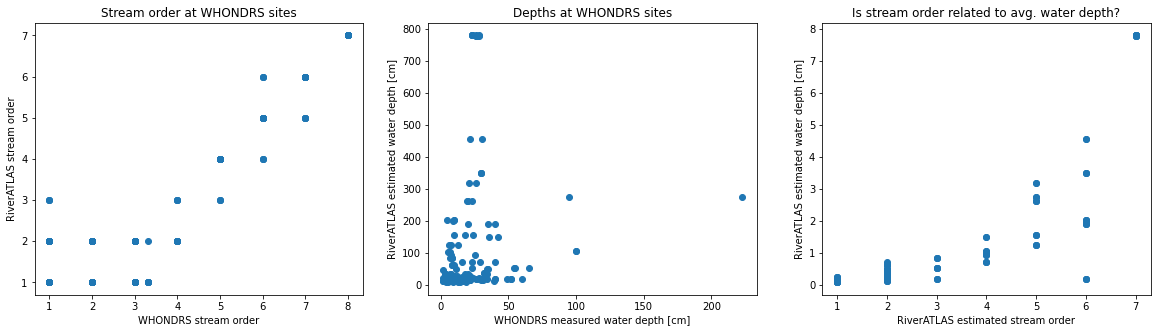

In [21]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=[20,5])
ax0.scatter(
    all_data_w_outliers.loc[:,'Stream_Order'],
    all_data_w_outliers.loc[:,'RA_SO'])
ax0.set_xlabel('WHONDRS stream order')
ax0.set_ylabel('RiverATLAS stream order')
ax0.set_title('Stream order at WHONDRS sites')

ax1.scatter(
    all_data_w_outliers.loc[:,'US_Water.Column.Height_cm'],
    100*all_data_w_outliers.loc[:,'RA_dm'])
ax1.set_xlabel('WHONDRS measured water depth [cm]')
ax1.set_ylabel('RiverATLAS estimated water depth [cm]')
ax1.set_title('Depths at WHONDRS sites')

ax2.scatter(
    all_data_w_outliers.loc[:,'RA_SO'],
    all_data_w_outliers.loc[:,'RA_dm'])
ax2.set_xlabel('RiverATLAS estimated stream order')
ax2.set_ylabel('RiverATLAS estimated water depth [cm]')
ax2.set_title('Is stream order related to avg. water depth?')


In [22]:
#all_data_ready4ml.loc[:,'RA_dm'].std()
#all_data_ready4ml.loc[:,'US_Water.Column.Height_cm'].max()
print(all_data_w_outliers.loc[:,('US_Water.Column.Height_cm','RA_dm')].corr())
print(all_data_w_outliers.loc[:,('Stream_Order','RA_SO')].corr())
print(all_data_w_outliers.loc[:,('RA_SO','RA_dm')].corr())

                           US_Water.Column.Height_cm    RA_dm
US_Water.Column.Height_cm                    1.00000  0.19557
RA_dm                                        0.19557  1.00000
              Stream_Order     RA_SO
Stream_Order      1.000000  0.916824
RA_SO             0.916824  1.000000
          RA_SO     RA_dm
RA_SO  1.000000  0.800975
RA_dm  0.800975  1.000000


# Final ranges of input data for parameter space extent

In [23]:
pd.set_option('display.max_columns', None)
all_data_ready4ml.describe()

,US_Latitude_dec.deg,US_Water.Column.Height_cm,US_Algal.Mat.Coverage,US_Macrophyte.Coverage,US_Sunlight.Access_Perc.Canopy.Cover,SW_pH,DO_perc.sat,DO_mg.per.L,SW_Temp_degC,Stream_Order,NOSC,lamO2,lamHCO3,n_chems,skew_lamO2,skew_lamHCO3,perc_AminoSugar,perc_Carb,perc_ConHC,perc_Lignin,perc_Lipid,perc_Other,perc_Protein,perc_Tannin,perc_UnsatHC,del_2H_permil,del_18O_permil,RA_SO,RA_dm,RA_ms_av,RA_ms_mn,RA_ms_mx,run_mm_cyr,dor_pc_pva,gwt_cm_cav,ele_mt_cav,slp_dg_cav,sgr_dk_rav,tmp_dc_cyr,tmp_dc_cdi,tmp_dc_uyr,pre_mm_cyr,pre_mm_cdi,pre_mm_uyr,aet_mm_cyr,aet_mm_cdi,aet_mm_uyr,cmi_ix_cyr,cmi_ix_cdi,cmi_ix_uyr,snw_pc_cyr,snw_pc_cmx,snw_pc_uyr,for_pc_cse,for_pc_use,crp_pc_cse,crp_pc_use,pst_pc_cse,pst_pc_use,ire_pc_cse,ire_pc_use,gla_pc_cse,gla_pc_use,prm_pc_cse,prm_pc_use,pac_pc_cse,pac_pc_use,cly_pc_cav,cly_pc_uav,slt_pc_cav,slt_pc_uav,snd_pc_cav,snd_pc_uav,soc_th_cav,soc_th_uav,swc_pc_cyr,swc_pc_cdi,swc_pc_uyr,kar_pc_cse,kar_pc_use,ero_kh_cav,ero_kh_uav,pop_ct_csu,pop_ct_usu,ppd_pk_cav,ppd_pk_uav,urb_pc_cse,urb_pc_use,nli_ix_cav,nli_ix_uav,rdd_mk_cav,rdd_mk_uav,hft_ix_c09,hft_ix_u09,gdp_md_cav,gdp_md_usu,hdi_ix_cav,General_Vegetation_Broadleaf deciduous tree,General_Vegetation_Broadleaf deciduous tree. Crop,General_Vegetation_Broadleaf deciduous tree. Grass,General_Vegetation_Broadleaf deciduous tree. Shrub,General_Vegetation_Broadleaf evergreen tree,General_Vegetation_Broadleaf evergreen tree. Broadleaf deciduous tree,General_Vegetation_Grass,General_Vegetation_Needleleaf deciduous tree. Broadleaf deciduous tree,General_Vegetation_Needleleaf deciduous tree. Grass,General_Vegetation_Needleleaf evergreen tree,General_Vegetation_Needleleaf evergreen tree. Broadleaf deciduous tree,General_Vegetation_Needleleaf evergreen tree. Broadleaf evergreen tree,General_Vegetation_Needleleaf evergreen tree. Grass,General_Vegetation_Needleleaf evergreen tree. Shrub,General_Vegetation_Shrub,General_Vegetation_Shrub. Grass,Hydrogeomorphology_Multi-channel,Hydrogeomorphology_Single-channel meandering,Hydrogeomorphology_Single-channel straight,River_Gradient_Relatively flat/gentle gradient (e.g. valleys),River_Gradient_Relatively steep gradient (e.g. mountainous or hilly terrain),Sediment_Bedrock (primarily),Sediment_Gravel/cobble (gt2mm),Sediment_Sand,Sediment_Silt/mud (lt0.0625mm),US_Depositional.Type_Downstream from obstacles,US_Depositional.Type_Downstream of small tributary,US_Depositional.Type_Inside bend of a stream,US_Depositional.Type_Marsh,US_Depositional.Type_Pool lip,US_Depositional.Type_Riffle,US_Depositional.Type_Shallow waters near the shore,US_Depositional.Type_Upstream of weir barrier deposition,rate.mg.per.L.per.h
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.00000,179.000000,179.00000,179.00000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.00000,179.000000,179.00000,179.000000,179.00

# Setting up Simulearner

Once the csv file is created, we need to prepare the data to run on the Simulearner.

1. Point the Simulearner workflow to the input data by creating a new directory `/pw/projects/whondrml/`.

2. Copy the csv files created by this notebook into `/pw/projects/whondrml` (the file with intputs/output and the file with just inputs).

3. Copy/create a Simulearner algorithm definition file `alg_meta.json` which lists the inputs and outputs in the `.csv` file associated with each of the ML models that will be fit and/or run by the Simulearner.  Also, copy/create `pbounds.json` to define the parameter bounds for the parameter optimization part of the workflow (if desired).  See the Simulearner documentation, below or in the Simulearner workflow, for more details.  The files used for ML in this workbook is stored in this repository `sbir-learnerworks-doc/sl_files`.

4. Run the Simulearner workflow via the ParallelWorks interface by selecting the `.csv` (point \#2 in this list) and `.json` files (point \#3 on this list).

5. The results of the Simulearner workflow go into the directory specified at the very bottom of the workflow form.  They are plotted below.

In [ ]:
# Load Simulearner results
# Using the results from removing the outlier at row 126.
# Activate the commented out datasets to see the whole dataset.
df_fit_data = pd.read_csv(
    '/pw/projects/whondrml/whondrml_intermediate_no_row_126.csv')
#    '/pw/projects/whondrml/whondrml_intermediate.csv')
df_pre_data = pd.read_csv(
     '/pw/projects/whondrml/SL-WHONDRML_006-20200904-223004-pred.csv')   
#    '/pw/projects/whondrml/SL-WHONDRML_005-20200828-153058-pred.csv')

# Plot the data used to fit the models to the predictions
fig, ax = plt.subplots()
plt.scatter(
    df_fit_data.loc[:,'rate.mg.per.L.per.h'],
    df_pre_data.loc[:,'rate.mg.per.L.per.h'])
ax.set_xlabel('Observations used in fitting [O2 mg/L/h]')
ax.set_ylabel('Predicted w/ same inputs [O2 mg/L/h]')
ax.set_title('Observations versus predictions')
plt.show()


In [ ]:
# Find the RMSE
error = (df_fit_data.loc[:,'rate.mg.per.L.per.h']-df_pre_data.loc[:,'rate.mg.per.L.per.h'])
squared_error = np.square(error)
mean_squared_error = np.mean(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
fit_range = df_fit_data.loc[:,'rate.mg.per.L.per.h'].max() - df_fit_data.loc[:,'rate.mg.per.L.per.h'].min()
fit_mean = np.mean(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
fit_std = np.std(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
#normalized_rmse = root_mean_squared_error/
normalized_rmse = root_mean_squared_error/fit_std
print(root_mean_squared_error, normalized_rmse)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Using model 20201111-153810
# Commented out files correspond to plot in feature
# permutation report to PNNL (testing data set)
# RMSD = 5.7
# Active lines correspond to training data set
# RMSD = 5.5
# Load Simulearner results
# Using the results from removing the outlier at row 126.
# Activate the commented out datasets to see the whole dataset.
df_fit_data = pd.read_csv(
#    '/pw/projects/whondrml/whondrml_test_withtarget.csv')
    '/pw/projects/whondrml/whondrml_train.csv')
df_pre_data = pd.read_csv(
#     '/pw/storage/SL-CaseName-20210105-185826-pred.csv')   
     '/pw/storage/SL-CaseName-20210105-191126-pred.csv')

# Plot the data used to fit the models to the predictions
fig, ax = plt.subplots()
plt.scatter(
    df_fit_data.loc[:,'rate.mg.per.L.per.h'],
    df_pre_data.loc[:,'rate.mg.per.L.per.h'])
ax.set_xlabel('Observations used in fitting [O2 mg/L/h]')
ax.set_ylabel('Predicted w/ same inputs [O2 mg/L/h]')
ax.set_title('Observations versus predictions')
plt.show()

# Find the RMSE
error = (df_fit_data.loc[:,'rate.mg.per.L.per.h']-df_pre_data.loc[:,'rate.mg.per.L.per.h'])
squared_error = np.square(error)
mean_squared_error = np.mean(squared_error)
root_mean_squared_error = np.sqrt(mean_squared_error)
fit_range = df_fit_data.loc[:,'rate.mg.per.L.per.h'].max() - df_fit_data.loc[:,'rate.mg.per.L.per.h'].min()
fit_mean = np.mean(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
fit_std = np.std(df_fit_data.loc[:,'rate.mg.per.L.per.h'])
#normalized_rmse = root_mean_squared_error/
normalized_rmse = root_mean_squared_error/fit_std
print(root_mean_squared_error, normalized_rmse)

### Plot your data
- Pairplot
- Correlation Heatmap

In [24]:
#num_inputs = 46+6+10
num_inputs = 130
param_names = list(all_data_ready4ml)
input_names = param_names[0:num_inputs]
output_names = param_names[num_inputs:]
#sns.pairplot(all_data_ready4ml, height=3, aspect=2, x_vars = input_names, y_vars = output_names)
plt.show()

<AxesSubplot:>

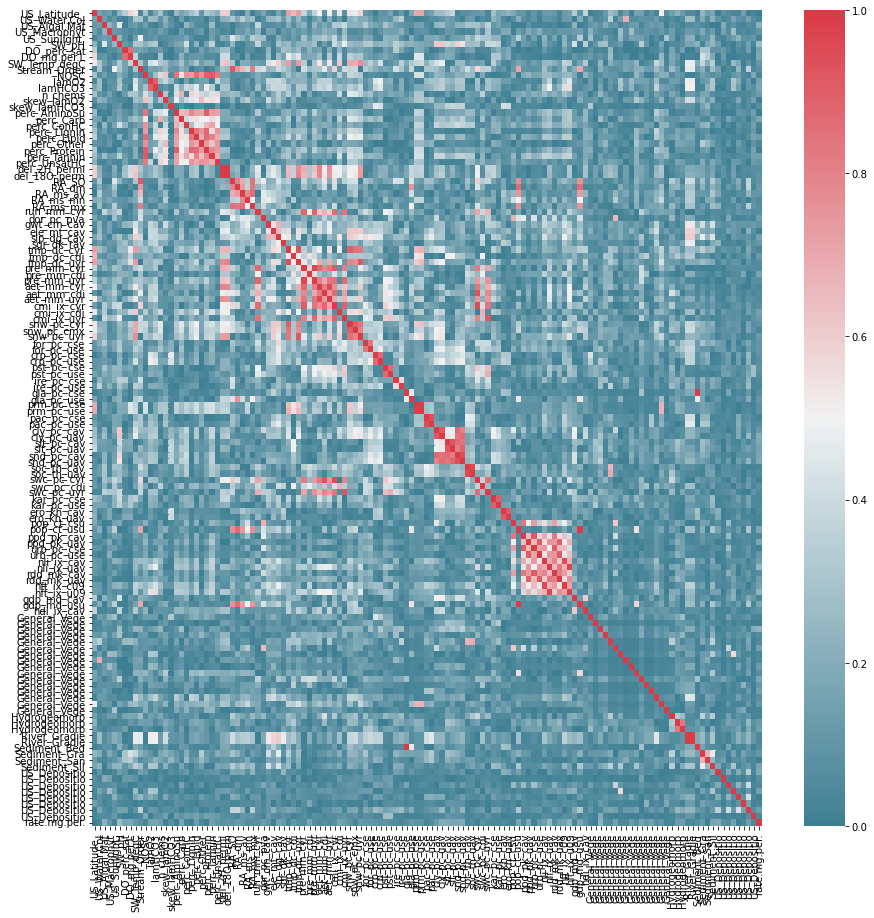

In [25]:
fig, ax = plt.subplots(figsize=(15,15))
corr = all_data_ready4ml.corr()
short_names = [name[:12] for name in corr.columns]
sns.heatmap(ax=ax, data=np.abs(corr), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))

In [27]:
sns.heatmap(ax=ax, data=np.abs(corr), xticklabels=short_names, yticklabels=short_names, cmap=sns.diverging_palette(220, 10, as_cmap=True,n=3))

<AxesSubplot:>

In [ ]:
# Get a list of the correlations between each input and the one output.
pd.set_option('display.max_rows', None)
corr.loc[:,'rate.mg.per.L.per.h']

In [ ]:
# Find the mean, std, and maximum correlation.
corr.iloc[0:num_inputs,num_inputs].abs().mean(),corr.iloc[0:num_inputs,num_inputs].abs().std(),corr.iloc[0:num_inputs,num_inputs].abs().max()

Visualize the dataframe with interactive pivot tables:

In [ ]:
#pivot(all_data_ready4ml)

Sort and filter data with interactive table:

In [ ]:
#from qgrid import show_grid
#grid = show_grid(all_data_ready4ml,show_toolbar=True)
#grid

Get the changed dataframe from the above filters:

In [ ]:
#ndf = grid.get_changed_df()
#ndf

### Select subset of your data based on constraints

Display columns available for doe filtering parameters:

In [ ]:
#for x in df.columns:
#    print(x)

Start the doe_graph filtering module with predefined filters (using column parameters above):

In [ ]:
params = [
    {
        'label':'EGR vs SOOT',
        'x_axis':'EGR',
        'y_axis':'SOOT',
        'color_by':'ISFC',
        'size_by':'NOX',
        'outputs':['index','EGR','SOOT','ISFC'],
        'constraints':[
         {
                'param':'PMAX',
                'op':'<',
                'val':220
            },
            {
                'param':'MPRR',
                'op':'<=',
                'val':15
            },
            {
                'param':'SOOT',
                'op':'<',
                'val': 0.0268
            },
               {
                'param':'NOX',
                'op':'<',
                'val':1.34
            }
        ]
    }
]

#doe_graph(df,params=params,height=800)

### Save the selected / filtered data into a CSV file

In [ ]:
#training_data = selected_data()
#file='/pw/sample_io/selected_data.csv'
#with open(file,'w') as f:
#    f.write(training_data.to_csv(index=False))
#training_data

## SuperLearner Workflow

The superlearner workflow runs up to 5 tasks:
- Hyperparameter optimization (HPO)
- Fit SuperLearner model (SL)
- Use SL to make predictions
- Calculate the root mean square error (RMSE) of a SL
- Run surrogate microGA optimization using a SL

These tasks are connected as shown in the image below. Thefore, if _HPO_ and _Fit_ are selected the workflow will first run HPO to obtain a set of optimized hyperparameters and then use these to train a SL. However, the user may also define their own HP and skip the optimization step. Similarly, the user may choose to fit a new SL or to upload an existing SL to run prediction, RMSE calculation and/or microGA optimization tasks.

<div style="text-align:left;"><img src="https://drive.google.com/uc?id=1b0zXq9egkMrrcDj-2TnRk54ecQwNxM6X" height="220"></div>

Each of these tasks or workflow sections will be described in the sections below.

### ML Model Definition:
To define a new model the following files must be modified in the `ml` directory:

#### define_algorithms.py
A function in name `def_algname` where `algname` is the algorithm's name must be added to this file. The function must take the algorithm's hyperparameters as inputs and return the ML model. See the file for some examples.


#### algorithms.py
Define your algorithm using the [scikit-learn API elements](https://scikit-learn.org/stable/developers/develop.html). This is, python objects with (at least) fit and predict methods that take the hyperparameters as inputs during intialization. See the file for an example.


### Hyperparameters
[Bayesian optimization](https://github.com/fmfn/BayesianOptimization) is used to run HPO. The HPO for for every algorithm and output parameter is run in parallel.

#### Inputs:
Choose whether to optimize the hyperparameters or use existing ones. If both options are chosen the existing hyperparemeters will be used in case the HPO task fails.

1. Data in CSV format: training data in CSV format with the name of the input and output parameters in the header and the inputs in the first columns (see image in Fit section).

2. JSON file with the bounds `[min, max]` for every hyperparameter in every ML model as shown in the example below for the _bfm_, _xgb_ and _ann_ algorithms.
3. Number of inputs (N): The first N columns in the data CSV will be used as inputs and the the rest as outputs.
4. Number of optimization iterations in the bayesian optimization algorithm.
5. Number of initial points in the bayesian optimization algorithm
6. Algorithm List: List of the ML models for the SL to train, validate and weight.

```
{
    "bfm": {
        "alpha_in": "(-6, -1)",
        "degree_in": "(1, 2)"
        },
    "xgb": {
        "numest_in": "(2, 5)",
        "lr_in": "(-3, 0)",
        "maxdepth_in": "(2, 30)"
        },
    "ann": {
        "lr_in": "(-5, -1)",
        "ann_structure": "(9, 80)"
    }
 }

```



#### Outputs:
JSON file with the hyperparameters for every target and ML model as shown in the example below for the targets _ISFC_ and _SOOT_, and the models _bfm_, _xgb_ and _ann_.


```{
    "ISFC": {
        "bfm": {
            "alpha_in": -1,
            "degree_in": 3
        },
        "xgb": {
            "lr_in": -1,
            "maxdepth_in": 4,
            "numest_in": 3
        },
        "ann": {
            "ann_structure": 15,
            "lr_in": -1.3
        }
    },
    "SOOT": {
        "bfm": {
            "alpha_in": -1,
            "degree_in": 3
        },
        "xgb": {
            "lr_in": -1,
            "maxdepth_in": 4,
            "numest_in": 3
        },
        "ann": {
            "ann_structure": 15,
            "lr_in": -1.3
        }
    }
}
```



### SuperLearner (Fit)

The SL is an ensemble stacking approach to machine learning (ML) that trains, validates and optimally combines several machine learning models to minimize the generalization error. Every stacked ML model is trained in parallel for every output parameter (target) using a sample of the training data (training set), as shown in the image below. Once trained, the models are assigned different weights for each target to minimize the generalization error on the remaining training data (validation set).


<div style="text-align:left;"><img src="https://drive.google.com/uc?id=1NDQ2giRPotOlhu__qcPagOv9XSLS3qip" height="650"></div>



See the article [_A Machine Learning-Genetic
Algorithm (ML-GA) Approach
for Rapid Optimization Using
High-Performance Computing_](https://www.sae.org/publications/technical-papers/content/2018-01-0190/) for more technical information.

#### Inputs
Choose whether to fit a new SL or use an existing SL. If both options are chosen the existing SL will be used in case the training task fails.

1. Hyperparameters for every output and ML model as seen in the section _Hyperparameters_.
2. Data in CSV format: training data in CSV format with the name of the input and output parameters in the header and the inputs in the first columns (see image above).
3. Number of inputs (N): The first N columns in the data CSV will be used as inputs and the the rest as outputs.
4. Training ratio: Ratio of the data used as training set to train each of the ML algorithms (see image above). The rest of the training data is used as validation set.
5. Algorithm List: List of the ML models for the SL to train, validate and weight.


#### Outputs
A ZIP file with the SL model. The SL can be loaded from this file. Note that tensorflow models cannot be saved as a PKL file.


### Predict
TODO

### RMSE
TODO

### MicroGA Optimization

TODO


### Requirements:
The workflow uses the `parsl-pw` conda environment. The following packages are required:

```
source /pw/.miniconda3/etc/profile.d/conda.sh
conda activate parsl-pw
conda install scikit-learn
conda install -c conda-forge bayesian-optimization
conda install pandas
conda install tensorflow
conda install matplotlib
conda install numpy
conda install scipy
conda install -c conda-forge xgboost
conda clean -all
conda list
/swift-pw-bin/parslab/packUserEnv.sh
```

In [ ]:
#workflow('simulearner',height=1000)